#Transfer Learning: Sign Language Classification
In this exercise, we will create a model for categorizing sign language images representing numbers 0-9. We will use a pre-trained model, Xception. In the dataset, 1712 images in the training set will be used, a validation set of 300 samples, and a test. Set all 50 samples with image size of 100 x 100 pixel RGB. <br>
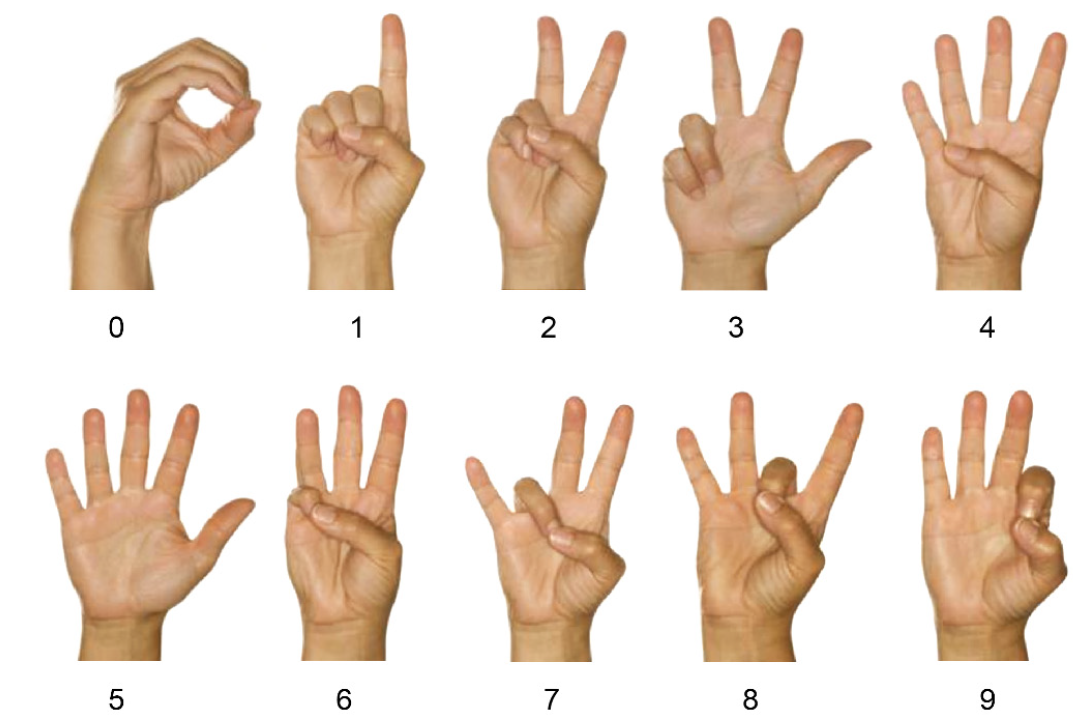
Source Datasets: from Deep Learning for Vision Systems Book

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
import os
import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling, RandomWidth, RandomHeight, Lambda
from tensorflow.keras.layers import SeparableConv2D, add, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras

#Data Collection

In [2]:
# install gdown package to download files from Google Drive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# download sign_language.zip from my Google Drive
!gdown --id 1RIrFK85tkcv0VffylXzPGGuML6CApNHr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1RIrFK85tkcv0VffylXzPGGuML6CApNHr
To: /content/sign_language.zip
100% 17.1M/17.1M [00:00<00:00, 226MB/s]


In [4]:
# let unzip sign_language.zip 
!unzip sign_language.zip

Archive:  sign_language.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/0/
  inflating: dataset/test/0/IMG_4159.JPG  
  inflating: dataset/test/0/IMG_4725.JPG  
  inflating: dataset/test/0/IMG_4976.JPG  
  inflating: dataset/test/0/IMG_5572.JPG  
  inflating: dataset/test/0/IMG_5695.JPG  
   creating: dataset/test/1/
  inflating: dataset/test/1/IMG_4497.JPG  
  inflating: dataset/test/1/IMG_5309.JPG  
  inflating: dataset/test/1/IMG_5340.JPG  
  inflating: dataset/test/1/IMG_5401.JPG  
  inflating: dataset/test/1/IMG_5992.JPG  
   creating: dataset/test/2/
  inflating: dataset/test/2/IMG_4727.JPG  
  inflating: dataset/test/2/IMG_5342.JPG  
  inflating: dataset/test/2/IMG_5594.JPG  
  inflating: dataset/test/2/IMG_5707.JPG  
  inflating: dataset/test/2/IMG_5718.JPG  
   creating: dataset/test/3/
  inflating: dataset/test/3/IMG_4184.JPG  
  inflating: dataset/test/3/IMG_5114.JPG  
  inflating: dataset/test/3/IMG_5279.JPG  
  inflating: dataset/test/3/IMG_5

In [5]:
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# load the data into train_dir, val_dir, and test_dir variables then generate batches of tensor image
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size = (100,100),
    batch_size = 64
)
val_dataset = image_dataset_from_directory(
    validation_dir,
    image_size = (100,100),
    batch_size = 64
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size = (100,100),
    batch_size = 64
)

Found 1712 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


In [ ]:
# try looking what is inside in each train_dataset
for data_batch, labels_batch in train_dataset.take(1):
  print("data batch shape", data_batch.shape)
  print("data batch shape", labels_batch.shape)
  print("labels_batch", labels_batch)

data batch shape (64, 100, 100, 3)
data batch shape (64,)
labels_batch tf.Tensor(
[6 5 3 3 1 2 2 0 0 7 2 6 3 7 9 8 2 0 5 3 1 5 4 7 8 8 3 7 2 2 4 3 8 1 6 5 3
 9 4 8 1 6 6 4 0 5 1 7 1 7 7 7 2 8 0 4 1 1 2 7 1 9 3 2], shape=(64,), dtype=int32)


# Train Model from Scratch

In [ ]:
# build model
def build_model_scratch():

  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape = (100,100,3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(25, activation = 'softmax'))
  
  return model

In [ ]:
# compile and fit model

# callbacks
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint_cb1 = ModelCheckpoint('model_scratch/woaugment', monitor='val_loss',save_best_only=True)
reduce_lr_cb = ReduceLROnPlateau(min_lr=0.001)

model = build_model_scratch()

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint_cb1,reduce_lr_cb])


Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 92.4393 - accuracy: 0.1034


27/27 [==============================] - 13s 146ms/step - loss: 92.4393 - accuracy: 0.1034 - val_loss: 3.1738 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 2.4492 - accuracy: 0.1291


27/27 [==============================] - 3s 96ms/step - loss: 2.4492 - accuracy: 0.1291 - val_loss: 2.7811 - val_accuracy: 0.2133 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 2.2261 - accuracy: 0.1951


27/27 [==============================] - 3s 101ms/step - loss: 2.2261 - accuracy: 0.1951 - val_loss: 1.9174 - val_accuracy: 0.3233 - lr: 0.0010
Epoch 4/50
26/27 [===========================>..] - ETA: 0s - loss: 1.9519 - accuracy: 0.3173


27/27 [==============================] - 3s 110ms/step - loss: 1.9425 - accuracy: 0.3213 - val_loss: 1.8035 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 1.6306 - accuracy: 0.4410


27/27 [==============================] - 3s 97ms/step - loss: 1.6306 - accuracy: 0.4410 - val_loss: 1.3414 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 1.3547 - accuracy: 0.5298


27/27 [==============================] - 3s 97ms/step - loss: 1.3547 - accuracy: 0.5298 - val_loss: 0.9380 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.5818


27/27 [==============================] - 3s 99ms/step - loss: 1.2140 - accuracy: 0.5818 - val_loss: 0.9187 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 8/50
27/27 [==============================] - ETA: 0s - loss: 0.9740 - accuracy: 0.6577


27/27 [==============================] - 3s 104ms/step - loss: 0.9740 - accuracy: 0.6577 - val_loss: 0.7295 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 9/50
27/27 [==============================] - 1s 45ms/step - loss: 0.8728 - accuracy: 0.6986 - val_loss: 0.7740 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 10/50
27/27 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.7278


27/27 [==============================] - 3s 95ms/step - loss: 0.8164 - accuracy: 0.7278 - val_loss: 0.7240 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 11/50
27/27 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.7617


27/27 [==============================] - 3s 96ms/step - loss: 0.6856 - accuracy: 0.7617 - val_loss: 0.5933 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 12/50
27/27 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.7856


27/27 [==============================] - 3s 106ms/step - loss: 0.6434 - accuracy: 0.7856 - val_loss: 0.5702 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 13/50
26/27 [===========================>..] - ETA: 0s - loss: 0.5517 - accuracy: 0.8167


27/27 [==============================] - 4s 147ms/step - loss: 0.5584 - accuracy: 0.8143 - val_loss: 0.5205 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 14/50
27/27 [==============================] - 2s 45ms/step - loss: 0.5352 - accuracy: 0.8154 - val_loss: 0.5211 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 15/50
27/27 [==============================] - 1s 43ms/step - loss: 0.4833 - accuracy: 0.8435 - val_loss: 0.5351 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 16/50
27/27 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.8452


27/27 [==============================] - 3s 96ms/step - loss: 0.4430 - accuracy: 0.8452 - val_loss: 0.4692 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 17/50
27/27 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8604


27/27 [==============================] - 3s 97ms/step - loss: 0.4094 - accuracy: 0.8604 - val_loss: 0.4643 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 18/50
27/27 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8674


27/27 [==============================] - 3s 108ms/step - loss: 0.3876 - accuracy: 0.8674 - val_loss: 0.4468 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 19/50
27/27 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8855


27/27 [==============================] - 3s 99ms/step - loss: 0.3384 - accuracy: 0.8855 - val_loss: 0.3977 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 20/50
27/27 [==============================] - 1s 45ms/step - loss: 0.3209 - accuracy: 0.8902 - val_loss: 0.4004 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 21/50
27/27 [==============================] - 1s 43ms/step - loss: 0.2931 - accuracy: 0.8896 - val_loss: 0.4114 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 22/50
27/27 [==============================] - 1s 44ms/step - loss: 0.3024 - accuracy: 0.8960 - val_loss: 0.4197 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 23/50
27/27 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9100


27/27 [==============================] - 3s 95ms/step - loss: 0.2500 - accuracy: 0.9100 - val_loss: 0.3865 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 24/50
27/27 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.9013


27/27 [==============================] - 3s 95ms/step - loss: 0.3007 - accuracy: 0.9013 - val_loss: 0.3701 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 25/50
27/27 [==============================] - 1s 45ms/step - loss: 0.2421 - accuracy: 0.9206 - val_loss: 0.4209 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 26/50
27/27 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9217


27/27 [==============================] - 3s 104ms/step - loss: 0.2369 - accuracy: 0.9217 - val_loss: 0.3684 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 27/50
27/27 [==============================] - 1s 46ms/step - loss: 0.1890 - accuracy: 0.9305 - val_loss: 0.3914 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 28/50
25/27 [==========================>...] - ETA: 0s - loss: 0.2350 - accuracy: 0.9244


27/27 [==============================] - 3s 95ms/step - loss: 0.2333 - accuracy: 0.9246 - val_loss: 0.3476 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 29/50
25/27 [==========================>...] - ETA: 0s - loss: 0.1680 - accuracy: 0.9381


27/27 [==============================] - 3s 96ms/step - loss: 0.1713 - accuracy: 0.9369 - val_loss: 0.3409 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 30/50
27/27 [==============================] - 1s 46ms/step - loss: 0.1745 - accuracy: 0.9433 - val_loss: 0.3714 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 31/50
27/27 [==============================] - 1s 43ms/step - loss: 0.1770 - accuracy: 0.9439 - val_loss: 0.3515 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 32/50
27/27 [==============================] - 1s 44ms/step - loss: 0.1720 - accuracy: 0.9439 - val_loss: 0.3835 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 33/50
27/27 [==============================] - 1s 44ms/step - loss: 0.1605 - accuracy: 0.9486 - val_loss: 0.3960 - val_accuracy: 0.9033 - lr: 0.0010


In [ ]:
# test set performance
model = keras.models.load_model('model_scratch/woaugment')
loss, acc = model.evaluate(test_dataset)
print('test_loss:', loss)
print('test_acc:', acc)

1/1 [==============================] - 0s 304ms/step - loss: 0.3391 - accuracy: 0.9000
test_loss: 0.3390621244907379
test_acc: 0.8999999761581421


#Pretrained Model as a Classifier

In [6]:
# load the data into train_dir, val_dir, and test_dir variables then generate batches of tensor image
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size = (299,299),
    batch_size = 64
)
val_dataset = image_dataset_from_directory(
    validation_dir,
    image_size = (299,299),
    batch_size = 64
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size = (299,299),
    batch_size = 64
)

Found 1712 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


In [ ]:
# load the Xception model and its pretrained weights
# https://keras.io/api/applications/xception/
model = Xception(weights="imagenet", include_top=True,input_shape=(299,299,3))
model.summary() 

91884032/91884032 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
# test set performance
pred = model.predict(test_dataset)
label = decode_predictions(pred)
print(label)

35363/35363 [==============================] - 0s 0us/step
[[('n03775546', 'mixing_bowl', 1.0), ('n04127249', 'safety_pin', 1.5998419e-17), ('n03942813', 'ping-pong_ball', 1.4894554e-38), ('n15075141', 'toilet_tissue', 0.0), ('n02391049', 'zebra', 0.0)], [('n03775546', 'mixing_bowl', 1.0), ('n03942813', 'ping-pong_ball', 1.7503249e-33), ('n15075141', 'toilet_tissue', 0.0), ('n02396427', 'wild_boar', 0.0), ('n02391049', 'zebra', 0.0)], [('n03775546', 'mixing_bowl', 1.0), ('n04127249', 'safety_pin', 2.6319735e-25), ('n15075141', 'toilet_tissue', 0.0), ('n02395406', 'hog', 0.0), ('n02389026', 'sorrel', 0.0)], [('n03775546', 'mixing_bowl', 1.0), ('n04127249', 'safety_pin', 2.0633836e-13), ('n15075141', 'toilet_tissue', 0.0), ('n02395406', 'hog', 0.0), ('n02389026', 'sorrel', 0.0)], [('n03775546', 'mixing_bowl', 1.0), ('n04127249', 'safety_pin', 8.7713785e-14), ('n03942813', 'ping-pong_ball', 6.056165e-34), ('n15075141', 'toilet_tissue', 0.0), ('n02391049', 'zebra', 0.0)], [('n03775546', 'm

# Pretrained Model as a Feature Extractor

In [ ]:
# without data augmentation
# include_top=False - remove the classifier part from this model 
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
conv_base.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_image = preprocess_input(images)
    features = conv_base.predict(preprocessed_image)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features),np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
train_features.shape 

2/2 [==============================] - 1s 1s/step


(1712, 10, 10, 2048)

In [ ]:
# build model

def build_model_feature_extractor1():
  model = Sequential()
  model.add(Flatten(input_shape=(last_layer.output_shape[1:])))
  model.add(Dense(512, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(25, activation='softmax'))
  return model

In [ ]:
# Freezing a layer
last_layer = conv_base.get_layer('block14_sepconv2')
last_layer.output_shape

(None, 10, 10, 2048)

In [ ]:
# compile and fit model

# callbacks
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint_cb3 = ModelCheckpoint('model_feature_extraction/woaugment', monitor='val_loss',save_best_only=True)
reduce_lr_cb = ReduceLROnPlateau(min_lr=0.001)

model = build_model_feature_extractor1()

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_features, train_labels, epochs=50, validation_data=(val_features, val_labels), verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint_cb3,reduce_lr_cb])

Epoch 1/50
54/54 [==============================] - 10s 181ms/step - loss: 1.0075 - accuracy: 0.7342 - val_loss: 1.4975 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 8s 155ms/step - loss: 0.1846 - accuracy: 0.9550 - val_loss: 0.3642 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 8s 152ms/step - loss: 0.1001 - accuracy: 0.9801 - val_loss: 0.2803 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 8s 158ms/step - loss: 0.0454 - accuracy: 0.9930 - val_loss: 0.2575 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 8s 152ms/step - loss: 0.0317 - accuracy: 0.9936 - val_loss: 0.2414 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 2s 39ms/step - loss: 0.0196 - accuracy: 0.9965 - val_loss: 0.2551 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 8s 152ms/step - lo

In [ ]:
# test set performance
model = keras.models.load_model('model_feature_extraction/woaugment')
loss, acc = model.evaluate(test_features,test_labels)
print('test_loss:', loss)
print('test_acc:', acc)

2/2 [==============================] - 0s 14ms/step - loss: 0.2277 - accuracy: 0.9400
test_loss: 0.2276657074689865
test_acc: 0.9399999976158142


In [ ]:
# with data augmentation 
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
conv_base.trainable = True 
for layer in conv_base.layers:
  print("layer name",layer.name, layer.trainable)
#Freezing a layer or set of layers means preventing their weights from being updated during training. 
#If you don’t do this, then the representations that were previously learned by the convolutional base will be modified 
conv_base.trainable = False # #With this setup, only the weights from the two Dense layers that you added will be trained. 
for layer in conv_base.layers:
  print("layer name",layer.name, layer.trainable)

layer name input_3 True
layer name block1_conv1 True
layer name block1_conv1_bn True
layer name block1_conv1_act True
layer name block1_conv2 True
layer name block1_conv2_bn True
layer name block1_conv2_act True
layer name block2_sepconv1 True
layer name block2_sepconv1_bn True
layer name block2_sepconv2_act True
layer name block2_sepconv2 True
layer name block2_sepconv2_bn True
layer name conv2d_11 True
layer name block2_pool True
layer name batch_normalization_9 True
layer name add_24 True
layer name block3_sepconv1_act True
layer name block3_sepconv1 True
layer name block3_sepconv1_bn True
layer name block3_sepconv2_act True
layer name block3_sepconv2 True
layer name block3_sepconv2_bn True
layer name conv2d_12 True
layer name block3_pool True
layer name batch_normalization_10 True
layer name add_25 True
layer name block4_sepconv1_act True
layer name block4_sepconv1 True
layer name block4_sepconv1_bn True
layer name block4_sepconv2_act True
layer name block4_sepconv2 True
layer name

In [16]:
# augmentation part
data_augmentation = Sequential(
  [
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomFlip('horizontal')
  ]
)

In [ ]:
# build model

def build_model_feature_extractor2():
  model = Sequential()
  model.add(Input(shape=(299,299,3)))
  model.add(data_augmentation)
  model.add(Lambda(lambda x: preprocess_input(x)))
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(25, activation='softmax'))
  return model

In [ ]:
# compile and fit model

# callbacks
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint_cb4 = ModelCheckpoint('model_feature_extraction/waugment', monitor='val_loss',save_best_only=True)
reduce_lr_cb = ReduceLROnPlateau(min_lr=0.001)

model = build_model_feature_extractor2()

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint_cb4, reduce_lr_cb])

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.9103 - accuracy: 0.5292


27/27 [==============================] - 53s 2s/step - loss: 1.9103 - accuracy: 0.5292 - val_loss: 2.3742 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.9317 - accuracy: 0.7144


27/27 [==============================] - 43s 2s/step - loss: 0.9317 - accuracy: 0.7144 - val_loss: 1.0341 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.7751


27/27 [==============================] - 43s 2s/step - loss: 0.6745 - accuracy: 0.7751 - val_loss: 0.5898 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.8271


27/27 [==============================] - 43s 2s/step - loss: 0.5489 - accuracy: 0.8271 - val_loss: 0.4766 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8546


27/27 [==============================] - 44s 2s/step - loss: 0.4445 - accuracy: 0.8546 - val_loss: 0.4213 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.8697


27/27 [==============================] - 43s 2s/step - loss: 0.3921 - accuracy: 0.8697 - val_loss: 0.4002 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8803


27/27 [==============================] - 43s 2s/step - loss: 0.3559 - accuracy: 0.8803 - val_loss: 0.3856 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 8/50
27/27 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.9025


27/27 [==============================] - 43s 2s/step - loss: 0.3283 - accuracy: 0.9025 - val_loss: 0.3074 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 9/50
27/27 [==============================] - 19s 689ms/step - loss: 0.2911 - accuracy: 0.9124 - val_loss: 0.3265 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 10/50
27/27 [==============================] - 20s 691ms/step - loss: 0.2733 - accuracy: 0.9118 - val_loss: 0.3153 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 11/50
27/27 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9235


27/27 [==============================] - 43s 2s/step - loss: 0.2610 - accuracy: 0.9235 - val_loss: 0.2561 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 12/50
27/27 [==============================] - 19s 677ms/step - loss: 0.2597 - accuracy: 0.9194 - val_loss: 0.3215 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 13/50
27/27 [==============================] - 19s 692ms/step - loss: 0.2571 - accuracy: 0.9100 - val_loss: 0.3543 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 14/50
27/27 [==============================] - 20s 705ms/step - loss: 0.2390 - accuracy: 0.9241 - val_loss: 0.3419 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 15/50
27/27 [==============================] - 20s 716ms/step - loss: 0.2591 - accuracy: 0.9100 - val_loss: 0.2947 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 16/50
27/27 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9410


27/27 [==============================] - 44s 2s/step - loss: 0.1923 - accuracy: 0.9410 - val_loss: 0.2464 - val_accuracy: 0.9233 - lr: 0.0010


In [ ]:
# test set performance
model = keras.models.load_model('model_feature_extraction/waugment')
loss, acc = model.evaluate(test_dataset)
print('test_loss:', loss)
print('test_acc:', acc)

1/1 [==============================] - 1s 1s/step - loss: 0.1571 - accuracy: 0.9800
test_loss: 0.15706095099449158
test_acc: 0.9800000190734863


#Fine-tuned 

In [7]:
# without data augmentation
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
conv_base.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [8]:
# build model
def build_model_fine_tuning1():
  model = Sequential()
  model.add(Input(shape=(299,299,3)))
  model.add(Lambda(lambda x: preprocess_input(x)))
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(25, activation='softmax'))
  return model


In [9]:
# Freezing a layer
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block9_sepconv1_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
  print("layer name",layer.name, layer.trainable)

layer name input_1 False
layer name block1_conv1 False
layer name block1_conv1_bn False
layer name block1_conv1_act False
layer name block1_conv2 False
layer name block1_conv2_bn False
layer name block1_conv2_act False
layer name block2_sepconv1 False
layer name block2_sepconv1_bn False
layer name block2_sepconv2_act False
layer name block2_sepconv2 False
layer name block2_sepconv2_bn False
layer name conv2d False
layer name block2_pool False
layer name batch_normalization False
layer name add False
layer name block3_sepconv1_act False
layer name block3_sepconv1 False
layer name block3_sepconv1_bn False
layer name block3_sepconv2_act False
layer name block3_sepconv2 False
layer name block3_sepconv2_bn False
layer name conv2d_1 False
layer name block3_pool False
layer name batch_normalization_1 False
layer name add_1 False
layer name block4_sepconv1_act False
layer name block4_sepconv1 False
layer name block4_sepconv1_bn False
layer name block4_sepconv2_act False
layer name block4_sepco

In [10]:
# compile and fit model

# callbacks
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint_cb5 = ModelCheckpoint('model_fine_tuning/woaugment', monitor='val_loss',save_best_only=True)
reduce_lr_cb = ReduceLROnPlateau(min_lr=0.001)

model = build_model_fine_tuning1()

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint_cb5, reduce_lr_cb])

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.8855


27/27 [==============================] - 73s 2s/step - loss: 0.5015 - accuracy: 0.8855 - val_loss: 0.9877 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9860


27/27 [==============================] - 52s 2s/step - loss: 0.0388 - accuracy: 0.9860 - val_loss: 0.3808 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 28s 1s/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.4921 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9965


27/27 [==============================] - 52s 2s/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.2492 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9965


27/27 [==============================] - 52s 2s/step - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.1599 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 28s 1s/step - loss: 0.0446 - accuracy: 0.9883 - val_loss: 0.2180 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 28s 1s/step - loss: 0.0256 - accuracy: 0.9942 - val_loss: 1.1369 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 8/50
27/27 [==============================] - 29s 1s/step - loss: 0.0139 - accuracy: 0.9965 - val_loss: 0.7705 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 9/50
27/27 [==============================] - 28s 1s/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.8360 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 10/50
27/27 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9988


27/27 [==============================] - 52s 2s/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.1242 - val_accuracy: 0.9767 - lr: 0.0010


In [11]:
# test set performance
model = keras.models.load_model('model_fine_tuning/woaugment')
loss, acc = model.evaluate(test_dataset)
print('test_loss:', loss)
print('test_acc:', acc)

1/1 [==============================] - 3s 3s/step - loss: 0.0072 - accuracy: 1.0000
test_loss: 0.007248053327202797
test_acc: 1.0


In [12]:
# with data augmentation
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [13]:
# build model

def build_model_fine_tuning2():
  model = Sequential()
  model.add(Input(shape=(299,299,3)))
  model.add(Lambda(lambda x: preprocess_input(x)))
  model.add(data_augmentation)
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(25, activation='softmax'))
  return model

In [14]:
# Freezing a layer
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block9_sepconv1_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
  print("layer name",layer.name, layer.trainable)

layer name input_3 False
layer name block1_conv1 False
layer name block1_conv1_bn False
layer name block1_conv1_act False
layer name block1_conv2 False
layer name block1_conv2_bn False
layer name block1_conv2_act False
layer name block2_sepconv1 False
layer name block2_sepconv1_bn False
layer name block2_sepconv2_act False
layer name block2_sepconv2 False
layer name block2_sepconv2_bn False
layer name conv2d_4 False
layer name block2_pool False
layer name batch_normalization_5 False
layer name add_12 False
layer name block3_sepconv1_act False
layer name block3_sepconv1 False
layer name block3_sepconv1_bn False
layer name block3_sepconv2_act False
layer name block3_sepconv2 False
layer name block3_sepconv2_bn False
layer name conv2d_5 False
layer name block3_pool False
layer name batch_normalization_6 False
layer name add_13 False
layer name block4_sepconv1_act False
layer name block4_sepconv1 False
layer name block4_sepconv1_bn False
layer name block4_sepconv2_act False
layer name bloc

In [17]:
# compile and fit model

# callbacks
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint_cb6 = ModelCheckpoint('model_fine_tuning/waugment', monitor='val_loss',save_best_only=True)
reduce_lr_cb = ReduceLROnPlateau(min_lr=0.001)

model = build_model_fine_tuning2()

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint_cb6, reduce_lr_cb])

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.7354


27/27 [==============================] - 61s 2s/step - loss: 1.0167 - accuracy: 0.7354 - val_loss: 1.1760 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9445


27/27 [==============================] - 54s 2s/step - loss: 0.1813 - accuracy: 0.9445 - val_loss: 0.5860 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9673


27/27 [==============================] - 55s 2s/step - loss: 0.0960 - accuracy: 0.9673 - val_loss: 0.2103 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 30s 1s/step - loss: 0.0843 - accuracy: 0.9743 - val_loss: 0.7895 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 30s 1s/step - loss: 0.0606 - accuracy: 0.9766 - val_loss: 0.8489 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 30s 1s/step - loss: 0.0441 - accuracy: 0.9866 - val_loss: 0.2599 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 30s 1s/step - loss: 0.0309 - accuracy: 0.9907 - val_loss: 0.2512 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 8/50
27/27 [==============================] - 30s 1s/step - loss: 0.0390 - accuracy: 0.9889 - val_loss: 0.3021 - val_accuracy: 0.9567 - lr: 0.0010


In [18]:
# test set performance
model = keras.models.load_model('model_fine_tuning/waugment')
loss, acc = model.evaluate(test_dataset)
print('test_loss:', loss)
print('test_acc:', acc)

1/1 [==============================] - 1s 1s/step - loss: 0.0819 - accuracy: 0.9600
test_loss: 0.08193836361169815
test_acc: 0.9599999785423279
